In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
import os, sys
sys.path.append('eval')
from forecast import *
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
graph_file = 'data/graphs_random/400950-400951_n2.json'

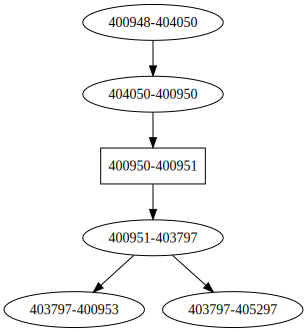

In [4]:
SROUTE, ADJ = read_graph(graph_file, 
                         verbose=False, named_adj=True)
graph = show_graph(SROUTE, ADJ)

EPS = 12
LAG = 24 + 1
STOPS = len(SROUTE)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
graph

In [31]:
dset = SpotHistory(SROUTE, 'train', 32, lag=LAG, res=10).generator()
valset = SpotHistory(SROUTE, 'test', 32, lag=LAG, res=10, shuffle=False).generator()

Chunks (lag 25)
 [*] Segments: 90 co-avail
    * [400950-400951]: 90
    * [400951-403797]: 90
    * [404050-400950]: 90
    * [400948-404050]: 90
    * [403797-400953]: 90
    * [403797-405297]: 90
 [*] Examples (train): 2678
 [*] No missing: 2678/4440
 [*] Time range: 2014-08-01 ~ 2014-10-31
Chunks (lag 25)
 [*] Segments: 90 co-avail
    * [400950-400951]: 90
    * [400951-403797]: 90
    * [404050-400950]: 90
    * [400948-404050]: 90
    * [403797-400953]: 90
    * [403797-405297]: 90
 [*] Examples (test): 870
 [*] No missing: 870/1131
 [*] Time range: 2014-08-01 ~ 2014-10-31


In [29]:
from models.temporal.RNN import *
from models.MPRNN import *
from models.Variants import *
  
HSIZE = 128
ITERS = 3
model = MPRNN_ITER(
    nodes=SROUTE, adj=ADJ, 
    hidden_size=HSIZE,
    
    iters=ITERS,
    iter_indep=False,
    
    rnnmdl=RNN,
    mpnmdl=MP_DENSE,
    
#     observations=True,
    
    verbose=True)

model.to(device)
model.device = device
model.clear_stats()

MPRNN
 [*] Defined over: 6 nodes
 [*] Contains    : 6 adjs
MPRNN_ITER
iters: 3
indep: False


In [32]:
criterion, opt, sch = model.params(lr=0.001)

In [33]:
evf = lambda: evaluate(
    valset, model, 
    crit=lambda _y, y: criterion(_y[:, :, 0], y[:, :, 0]).item())
_ = evf()

Eval loss: 9.2402           


In [34]:
train_mse = []
eval_mse = []
eval_mape = []
last_best = None

In [35]:

for eii  in range(EPS):
    bls = []
    for bii, batch in enumerate(dset):
        model.train()
        model.enable_jitter(True)
        Xs, Ys = model.format_batch(batch)
        
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        opt.step()

        bls.append(loss.item())
        bmse = ''
        if bii == len(dset) - 1:
            bmse = (10 ** 2 * np.mean(bls))
            train_mse.append(bmse)
            bmse = '(avg %.2f)' % bmse
        sys.stdout.write('[%d/%d : %d/%d] - L%.2f %s  \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            10**2 * loss.item(),
            bmse
        ))
    sys.stdout.write('\n')

    model.enable_jitter(False)
    escore = evf()
    if last_best is None or escore < last_best:
        print('Saving: %.3f > %.3f' % (last_best or -1, escore))
        last_best = escore
        torch.save(model.state_dict(), 'best.pth')
    eval_mse.append(escore)
    sys.stdout.flush()
#     sch.step()
# [8/12] Eval loss: 0.2163  
# [6/12] Eval loss: 0.2235 

[1/12 : 84/84] - L0.64 (avg 5.41)  
Eval loss: 0.6312          
Saving: -1.000 > 0.631
[2/12 : 84/84] - L0.24 (avg 0.36)  
Eval loss: 0.3224          
Saving: 0.631 > 0.322
[3/12 : 84/84] - L0.18 (avg 0.20)  
Eval loss: 0.3719          
[4/12 : 84/84] - L0.15 (avg 0.16)  
Eval loss: 0.4698          
[5/12 : 84/84] - L0.19 (avg 0.18)  
Eval loss: 0.2604          
Saving: 0.322 > 0.260
[6/12 : 84/84] - L0.14 (avg 0.14)  
Eval loss: 0.2752          
[7/12 : 84/84] - L0.11 (avg 0.13)  
Eval loss: 0.2629          
[8/12 : 84/84] - L0.12 (avg 0.12)  
Eval loss: 0.2589          
Saving: 0.260 > 0.259
[9/12 : 84/84] - L0.12 (avg 0.12)  
Eval loss: 0.2263          
Saving: 0.259 > 0.226
[10/12 : 84/84] - L0.10 (avg 0.12)  
Eval loss: 0.4015          
[11/12 : 84/84] - L0.10 (avg 0.12)  
Eval loss: 0.2882          
[12/12 : 84/84] - L0.14 (avg 0.12)  
Eval loss: 0.2713          


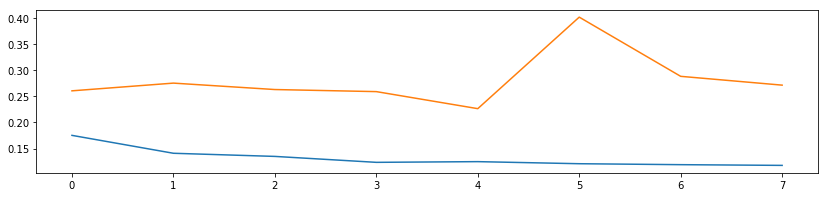

In [36]:
plt.figure(figsize=(14, 3))
plt.plot(train_mse[4:])
plt.plot(eval_mse[4:])
plt.show(); plt.close()

In [37]:
from utils import *
testset = SpotHistory(SROUTE, 'test', 18, lag=None, res=10, shuffle=False, verbose=True)
def xfmt(datain):
    bynode = torch.split(datain.to(device).float().unsqueeze(1), 1, 2)
    return bynode

Full history
 [*] Segments: 90 co-avail
    * [400950-400951]: 90
    * [400951-403797]: 90
    * [404050-400950]: 90
    * [400948-404050]: 90
    * [403797-400953]: 90
    * [403797-405297]: 90
 [*] Examples (test): 18
 [*] Time range: 2014-08-01 ~ 2014-10-31


In [42]:
# model.load_state_dict(torch.load('jitter.pth'))

FileNotFoundError: [Errno 2] No such file or directory: 'jitter.pth'

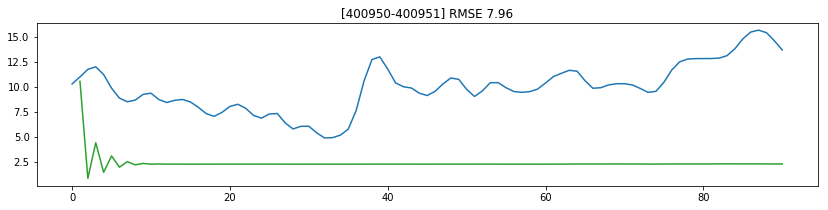

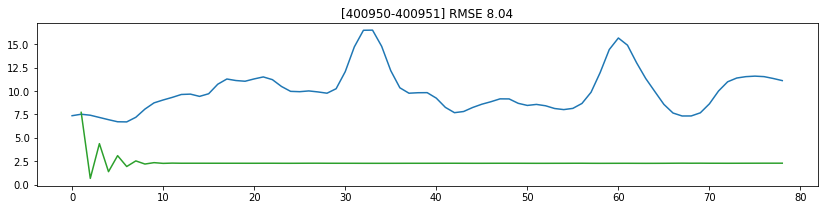

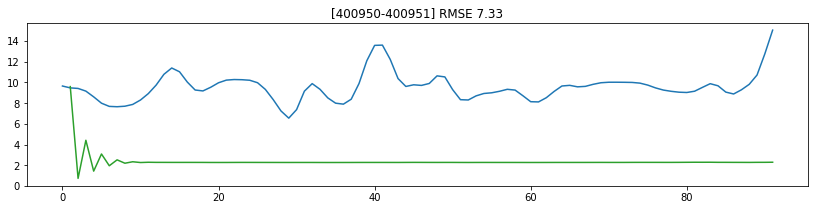

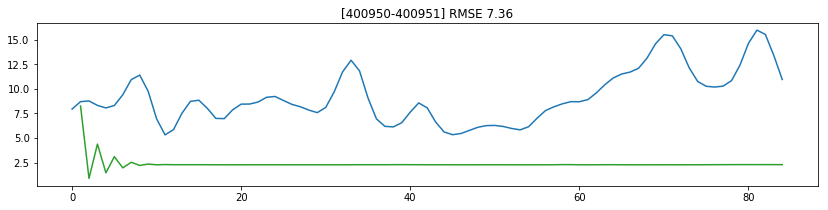

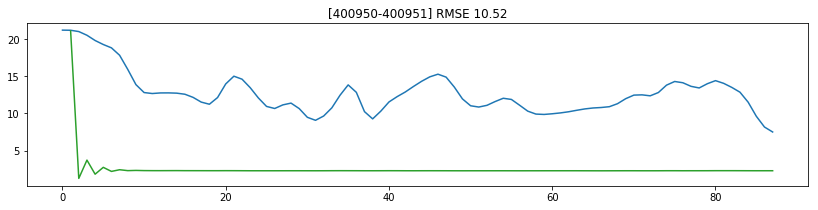

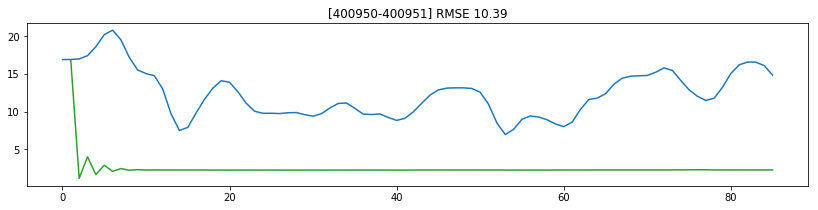

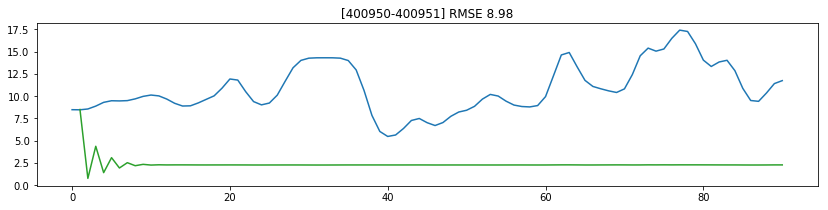

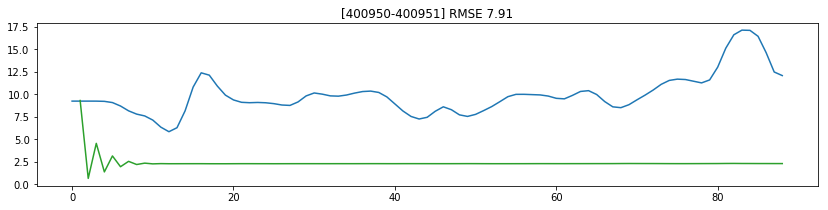

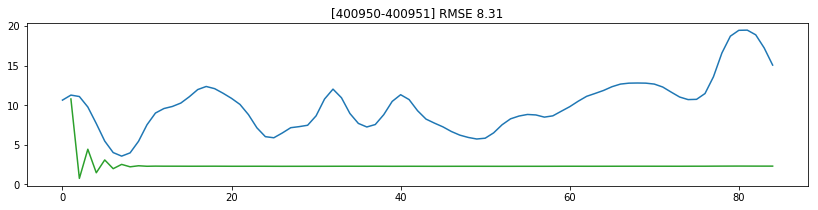

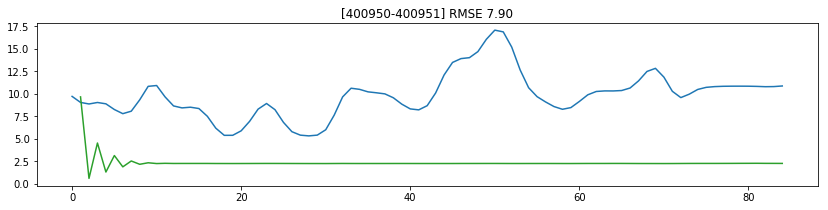

In [41]:
model.enable_jitter(False)
for ii in range(10):
    _ = forecast_mprnn(
        testset[ii], model, graph_file, 
        twoway=True,
        explicit=True,
        verbose=False, plot=True)

In [43]:
torch.save(model.state_dict(), 'expl.pth')

In [ ]:
# torch.save(model, 'checkpoints/mpnn_dense_H12_L00424.pth')
model.steps = len(SROUTE)
sqerr = eval_rnn(testset, model, plot=False, xfmt=xfmt)
print('Eval segments:', len(testset))
print('Eval MSE: %.4f' % np.mean(sqerr))
# 0.0148